In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patheffects as PathEffects
import random
from itertools import chain
from sklearn.decomposition import PCA
import time
import seaborn as sns

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [4]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('../p1_data/Data_Entry_2017.csv')

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(15)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
3138,00015449_002.png,No Finding,2,15449,039Y,F,PA,2992,2693,0.143000,0.143000
4193,00020607_001.png,No Finding,1,20607,053Y,F,PA,2992,2991,0.143000,0.143000
4257,00020979_007.png,Atelectasis,7,20979,045Y,M,PA,2992,2991,0.143000,0.143000
772,00004066_005.png,Effusion,5,4066,031Y,M,AP,2500,2048,0.171000,0.171000
544,00002799_000.png,No Finding,0,2799,050Y,F,PA,2048,2500,0.171000,0.171000
4885,00025718_001.png,No Finding,1,25718,050Y,M,PA,3056,2544,0.139000,0.139000
3643,00017940_001.png,No Finding,1,17940,033Y,M,PA,2992,2991,0.143000,0.143000
730,00003837_008.png,No Finding,8,3837,052Y,F,PA,2500,2048,0.168000,0.168000
3436,00016942_007.png,No Finding,7,16942,058Y,M,AP,2500,2048,0.168000,0.168000
5335,00028762_001.png,Effusion|Pleural_Thickening,1,28762,043Y,F,PA,1840,2021,0.194311,0.194311


In [5]:
## EDA
split_findings = all_xray_df['Finding Labels'].map(lambda x: x.split('|'))
labels = split_findings.tolist()
unique_labels = np.unique(list(chain(*labels)))
print('All Labels ({}): {}'.format(len(unique_labels), unique_labels))


# for each case (row), make a binary flag for whether this person has a disease or not
for ul in unique_labels:
    all_xray_df[ul] = all_xray_df['Finding Labels'].map(lambda finding: 1 if ul in finding else 0)
all_xray_df.head()

All Labels (15): ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0


In [6]:
# count number of diseases each person has
all_xray_df['Disease Count'] = split_findings.map(lambda x: len(x) if 'No Finding' not in x else 0)
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Disease Count
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,1
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,0,0,0,2
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,2
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,1,0,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,1,0,0,0,0,0,0,0,1


There are far more non-pneumonia cases in this dataset. This is a dataset of pneumonia in the wild, so it's not specifically for pneumonia.

In [7]:
penumonia_pos_count = len(all_xray_df[all_xray_df.Pneumonia == 1])
penumonia_neg_count = len(all_xray_df[all_xray_df.Pneumonia == 0])
print('Patients positive for pneumonia', penumonia_pos_count)
print('Patients negative for pneumonia', penumonia_neg_count)

Patients positive for pneumonia 1431
Patients negative for pneumonia 110689


We see that pneumonia often co-occurs with another disease(s), or is identified as a possible alternative to another diseases 77% of the time.

In [8]:
pneumonia_and_other = len(all_xray_df.loc[(all_xray_df.Pneumonia == 1) & (all_xray_df['Disease Count'] > 1)])
print('Patients positive for pneumonia and another disease', pneumonia_and_other)
print('Proportion', pneumonia_and_other / penumonia_pos_count)

Patients positive for pneumonia and another disease 1109
Proportion 0.7749825296995109


Pneumonia occurs 1.3% of the time in the dataset.

In [9]:
(all_xray_df[unique_labels].sum()/len(all_xray_df)).sort_values(ascending=False)

No Finding            0.538361
Infiltration          0.177435
Effusion              0.118775
Atelectasis           0.103095
Nodule                0.056466
Mass                  0.051570
Pneumothorax          0.047289
Consolidation         0.041625
Pleural_Thickening    0.030191
Cardiomegaly          0.024759
Emphysema             0.022440
Edema                 0.020540
Fibrosis              0.015037
Pneumonia             0.012763
Hernia                0.002025
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

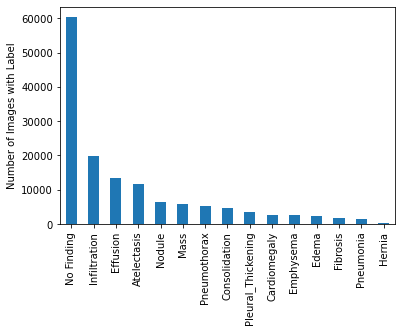

In [10]:
disease_barchart = all_xray_df[unique_labels].sum().sort_values(ascending=False).plot(kind='bar')
disease_barchart.set(ylabel = "Number of Images with Label")

Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences with penumonia. We see pneumonia is often identified along with infiltration and edema. Indeed, pulmonary infiltrates are associated with pneumonia and inflammation due to pneumonia causes fluid leakage and buildup which resembles edema.

Pneumonia                                                                                         322
Infiltration|Pneumonia                                                                            199
Edema|Infiltration|Pneumonia                                                                      137
Atelectasis|Pneumonia                                                                             108
Edema|Pneumonia                                                                                    83
                                                                                                 ... 
Effusion|Infiltration|Mass|Nodule|Pneumonia                                                         1
Atelectasis|Consolidation|Edema|Effusion|Infiltration|Mass|Nodule|Pleural_Thickening|Pneumonia      1
Atelectasis|Cardiomegaly|Effusion|Infiltration|Pneumonia                                            1
Edema|Infiltration|Mass|Nodule|Pneumonia                                          

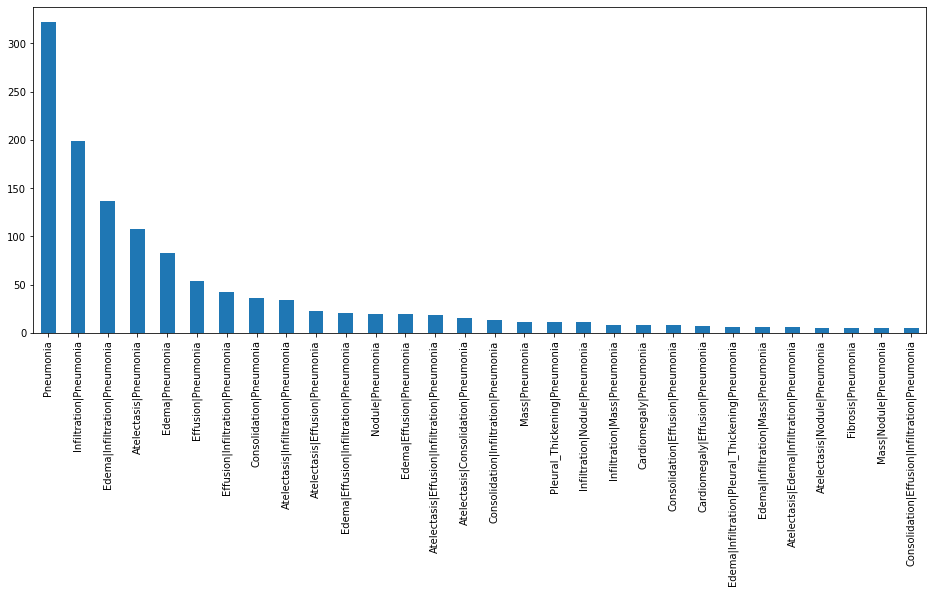

In [11]:
plt.figure(figsize=(16,6))
pneumonia_cooccurences = all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()
print(pneumonia_cooccurences)
pneumonia_cooccurences[0:30].plot(kind='bar')

First filter out the outlier ages (four hundreds).

In [12]:
# patient age
print(all_xray_df['Patient Age'].value_counts()) # we see there are outliers
print('Min age', all_xray_df['Patient Age'].min())
print('Max age', all_xray_df['Patient Age'].max())

58     3209
56     2916
52     2891
55     2830
57     2771
       ... 
411       1
413       1
414       1
95        1
152       1
Name: Patient Age, Length: 107, dtype: int64
Min age 1
Max age 414


In [13]:
from scipy import stats
all_xray_df = all_xray_df[(np.abs(stats.zscore(all_xray_df['Patient Age'])) < 3)] # remove outliers
print(all_xray_df['Patient Age'].value_counts().sort_values())
print('Min age', all_xray_df['Patient Age'].min())
print('Max age', all_xray_df['Patient Age'].max())
print('25th quantile age', all_xray_df["Patient Age"].quantile(0.25))
print('75th quantile age', all_xray_df["Patient Age"].quantile(0.75))

95       1
92       6
94       8
93       9
91      11
      ... 
57    2771
55    2830
52    2891
56    2916
58    3209
Name: Patient Age, Length: 95, dtype: int64
Min age 1
Max age 95
25th quantile age 35.0
75th quantile age 59.0


Now, we see that the dataset contains patients from 1 year old up to 95, with most 20-60 years old.

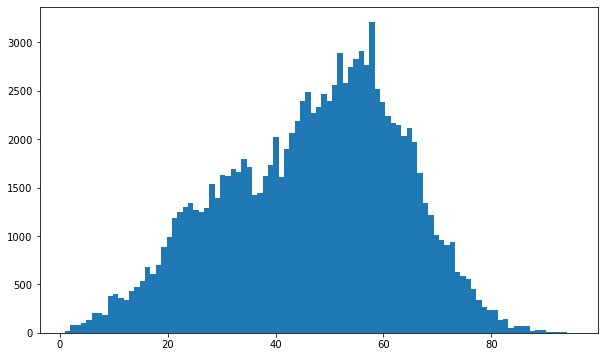

In [14]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Patient Age'], bins=95);

Most patients with penumonia are between 20 and 70.

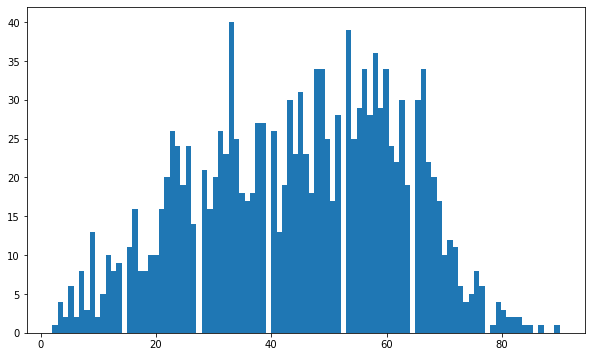

In [15]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'], bins=95);

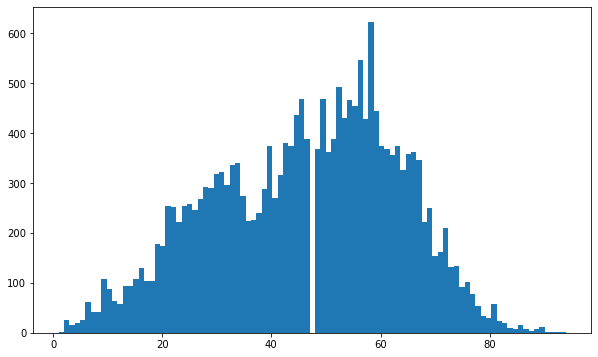

In [16]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Infiltration==1]['Patient Age'], bins=95);

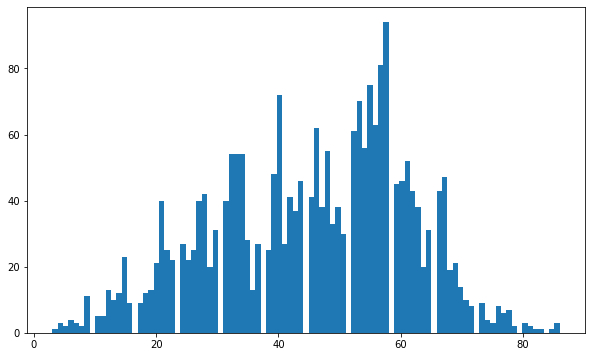

In [17]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Edema==1]['Patient Age'], bins=95);

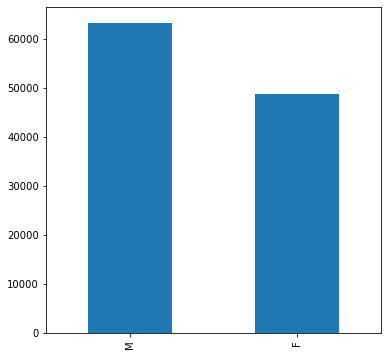

In [18]:
plt.figure(figsize=(6,6))
all_xray_df['Patient Gender'].value_counts().plot(kind='bar')

Pneumonia and conditions associated with pneumonia seem to affect men slightly more often than women.

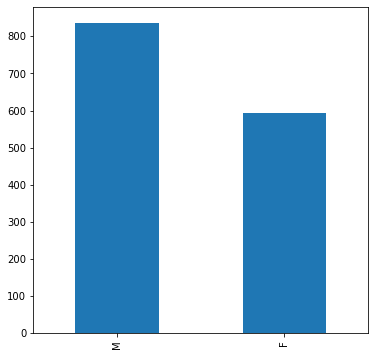

In [19]:
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia ==1]['Patient Gender'].value_counts().plot(kind='bar')

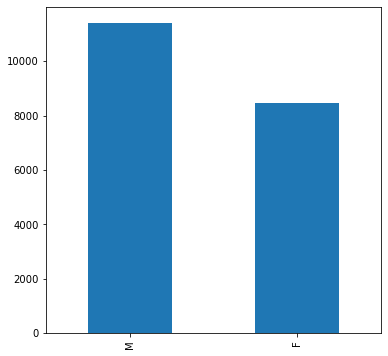

In [20]:
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Infiltration ==1]['Patient Gender'].value_counts().plot(kind='bar')

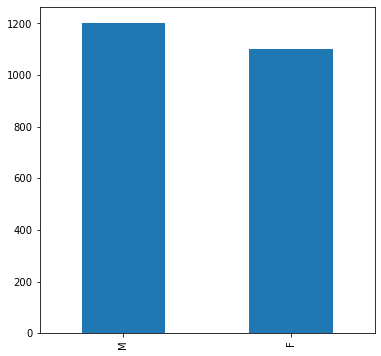

In [21]:
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Edema ==1]['Patient Gender'].value_counts().plot(kind='bar')

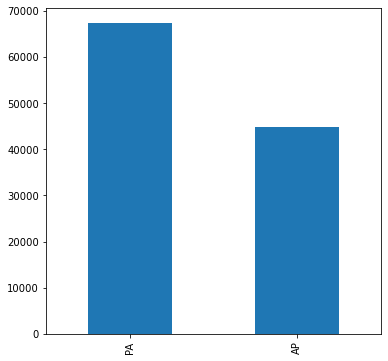

In [22]:
plt.figure(figsize=(6,6))
all_xray_df['View Position'].value_counts().plot(kind='bar')

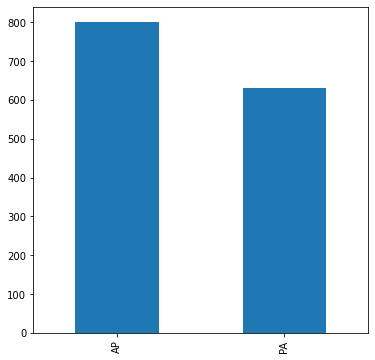

In [23]:
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia==1]['View Position'].value_counts().plot(kind='bar')

# Pixel analysis

In [24]:
img2path = {os.path.basename(x): x for x in 
                   glob(os.path.join('../p1_data','images*', '*', '*.png'))}

../p1_data/images_001/images/00000013_026.png


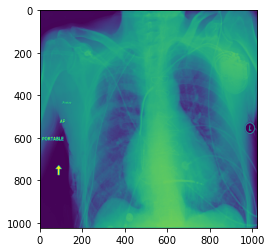

In [25]:
sample_img_path = img2path[sample_df["Image Index"].tolist()[1]]
print(sample_img_path)
sample_image = mpimg.imread(sample_img_path)
plt.imshow(sample_image)

In [26]:
split_findings = sample_df['Finding Labels'].map(lambda x: x.split('|'))
labels = split_findings.tolist()
unique_labels = np.unique(list(chain(*labels)))
print('All Labels ({}): {}'.format(len(unique_labels), unique_labels))

# for each case (row), make a binary flag for whether this person has a disease or not
for l in unique_labels:
    sample_df[l] = sample_df['Finding Labels'].map(lambda finding: 1 if l in finding else 0)
sample_df.sample(3)

All Labels (15): ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
1094,00005722_014.png,No Finding,14,5722,038Y,M,PA,2992,2991,0.143000,...,0,0,0,0,0,1,0,0,0,0
5599,00030695_002.png,Atelectasis,2,30695,052Y,F,PA,2021,2021,0.194311,...,0,0,0,0,0,0,0,0,0,0
1463,00007620_001.png,No Finding,1,7620,024Y,F,PA,2021,2021,0.194311,...,0,0,0,0,0,1,0,0,0,0


In [27]:
from skimage.transform import resize
img_size = (224,224)

def standardize_img(img):
    mean = np.mean(img)
    std = np.std(img)
    img_copy = img.copy()
    img_copy = (img_copy - mean) / std
    return img_copy

# X-Ray images contain a dark background which contributes to a large peak at intensity 0. 
# To have a nicer histogram of intensities for pneumonia, lets remove the background.
def image_mask_selection(img, threshold_low, threshold_up):
    img_copy = img.copy()
    mask = (img_copy > threshold_low) & (img_copy < threshold_up)
    img_copy = img_copy[mask]
    
    return img_copy

def rgb2gray(img):
    rgb_weights = [0.2989, 0.5870, 0.1140]
    return np.dot(img[...,:3], rgb_weights)

def read_img(img_id):
    filepath = img2path[img_id]
    img = mpimg.imread(filepath)
    
    return img

# utility to read in k numpy image arrays for each label
def read_k_images(labels, k):
    data = {}

    for condition in labels:
        data[condition] = []
        #ids = sample_df[sample_df[condition]==1]['Image Index'].tolist()
        ids = sample_df[sample_df["Finding Labels"]==condition]['Image Index'].tolist()
        sampling = random.sample(ids, k=min(k, len(ids)))

        for s_id in sampling:
            np_image = read_img(s_id)
            np_image = resize(np_image, img_size, anti_aliasing=False)
            data[condition].append(np_image.flatten())
        
    return data

def plot_histograms(images, title, limit):
    if limit:
        images = images[:limit]
    for img in images:
        plt.hist(image_mask_selection(img, threshold_low=0.1, threshold_up=0.95),
                 bins=256, histtype='stepfilled', alpha=0.5, 
                 density=True, stacked=True)
        plt.title(title)

In [29]:
#del label2images

In [30]:
label2images = read_k_images(unique_labels, k=500)

Lets plot the intensities of the images for pneumonia on top of each other.

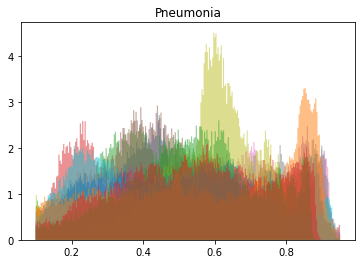

In [32]:
plot_histograms(label2images['Pneumonia'], title="Pneumonia", limit=None)

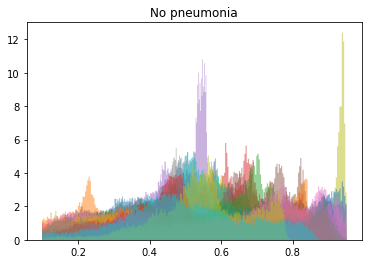

In [33]:
pneumonia_neg_imgs_bylabel = [label2images[label] for label in label2images if label != 'Pneumonia']
pneumonia_neg_imgs = []
for i in pneumonia_neg_imgs_bylabel:
    pneumonia_neg_imgs.extend(i)
plot_histograms(pneumonia_neg_imgs, title='No pneumonia', limit=50)

Now lets plot a summarized histogram of the intensities by finding. Perhaps that will be clearer than the above.

In [34]:
def get_condition_intensities(condition_images, threshold_low, threshold_up):
    intensities = []
    condition_images = condition_images[:min(150, len(condition_images))]
    
    for img in condition_images:
        image = image_mask_selection(img, threshold_low, threshold_up)
        intensities.extend(image.flatten())
    return intensities

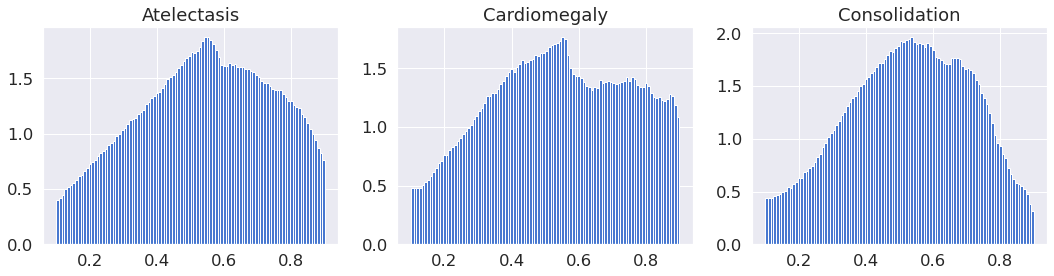

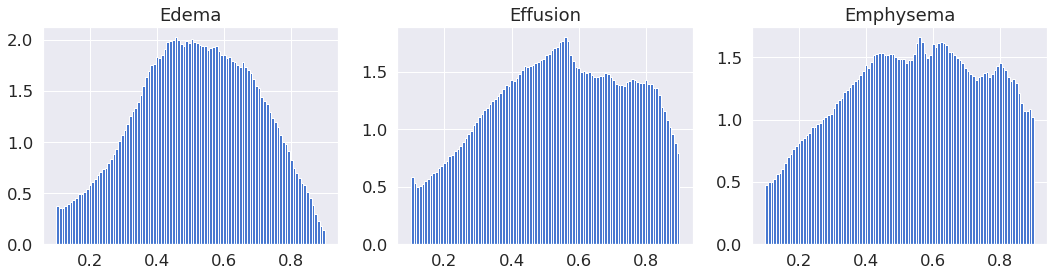

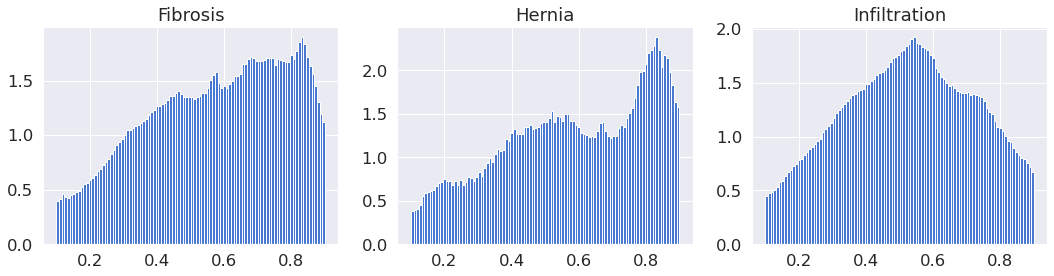

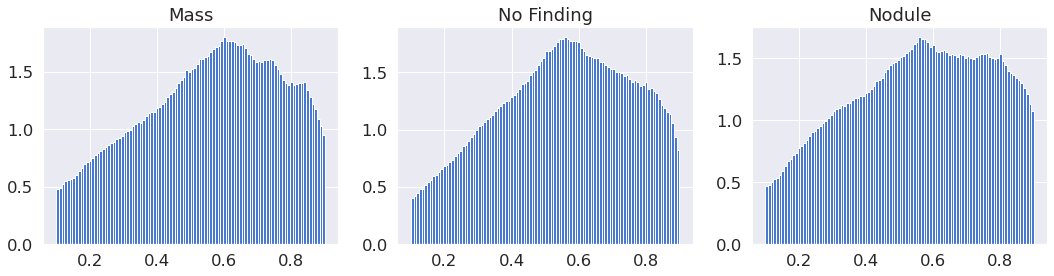

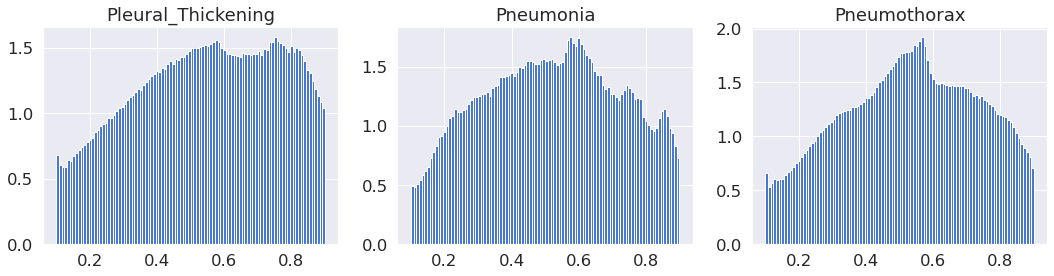

In [45]:
for i, label in enumerate(unique_labels):
    column = i % 3
    if column == 0:
        figure = plt.figure()
        figure.set_figwidth(18)
        
        x = figure.add_subplot(1, 3, column + 1)
        x.set_title(label)
    else:
        x = figure.add_subplot(1, 3, column + 1)
        x.set_title(label)

    intensities = get_condition_intensities(label2images[label], 0.1, 0.9)
    plt.hist(intensities, bins=100, density=True)

## PCA and t-SNE

Lets plot some PCA and t-SNE visualizations. I don't expect much given the similarities between x-rays, but I'm curious to see how it works. I'm going to run PCA with 50 dimensions, then pass the output to t-SNE based on the recommendation in Scikit-learn's documention:
```
It is highly recommended to use another dimensionality reduction method (e.g., PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g., 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples.
```

In [46]:
# Utility function to visualize the outputs of PCA and t-SNE
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
seed = 123
def scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [54]:
label2index = {label: i for i, label in enumerate(unique_labels)}

In [48]:
def gen_dim_reduction_data(label2images):
    images, labels = [], []
    for label in label2images:
        disease_imgs = label2images[label]
        bad_imgs_idxs = []
        for i, img in enumerate(disease_imgs):
            if img.shape != (img_size[0]*img_size[1],):
                bad_imgs_idxs.append(i)
                
        disease_imgs = [img for i, img in enumerate(disease_imgs) if i not in bad_imgs_idxs]
        
        np_disease_imgs = np.array(disease_imgs)
        print(label, np_disease_imgs.shape) # shape: (10, 224*224)
        
        images.extend(np_disease_imgs)

        label_index = label2index[label]
        labels.extend([label_index] * len(disease_imgs))
    return np.array(images), np.array(labels)

dim_reduction_imgs, dim_reduction_labels = gen_dim_reduction_data(label2images)
print(dim_reduction_imgs.shape, dim_reduction_labels.shape)

Atelectasis (192, 50176)
Cardiomegaly (50, 50176)
Consolidation (72, 50176)
Edema (41, 50176)
Effusion (202, 50176)
Emphysema (42, 50176)
Fibrosis (38, 50176)
Hernia (5, 50176)
Infiltration (500, 50176)
Mass (99, 50176)
No Finding (498, 50176)
Nodule (144, 50176)
Pleural_Thickening (65, 50176)
Pneumonia (14, 50176)
Pneumothorax (114, 50176)
(2076, 50176) (2076,)


In [49]:
time_start = time.time()

pca = PCA(n_components=50)
pca_result = pca.fit_transform(dim_reduction_imgs)

print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

PCA done! Time elapsed: 1.9796221256256104 seconds


In [50]:
pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4'])

pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1]
pca_df['pca3'] = pca_result[:,2]
pca_df['pca4'] = pca_result[:,3]

print('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

Variance explained per principal component: [0.25387734 0.09401213 0.08094388 0.07695524 0.06370968 0.04036744
 0.02762588 0.01981723 0.01878111 0.01545188 0.01413914 0.01311133
 0.01174686 0.0114534  0.01014816 0.0095368  0.00857099 0.00744773
 0.00695343 0.00678764 0.00593873 0.00557203 0.00522096 0.00485763
 0.00459936 0.00428363 0.00420225 0.004048   0.00387208 0.00365461
 0.00350033 0.0033326  0.0029011  0.00286546 0.00271008 0.00253865
 0.00246291 0.00223057 0.00211029 0.00201089 0.00196949 0.00193358
 0.00176508 0.00170481 0.00165575 0.00163503 0.00157869 0.00150558
 0.00141494 0.00139355]


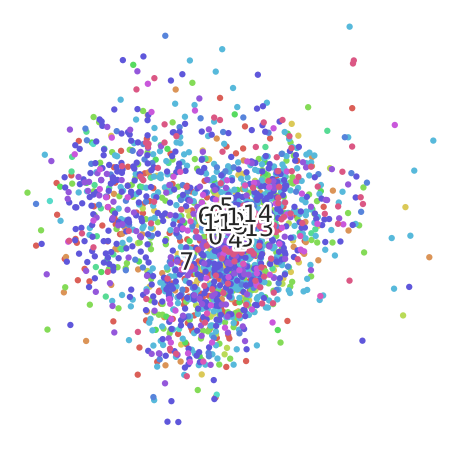

In [51]:
top_two_comp = pca_df[['pca1','pca2']] # taking first and second principal component
scatter(top_two_comp.values,dim_reduction_labels); # Visualizing the PCA output

In [52]:
from sklearn.manifold import TSNE

time_start = time.time()

tsne = TSNE(random_state=seed).fit_transform(pca_result)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 5.030672073364258 seconds


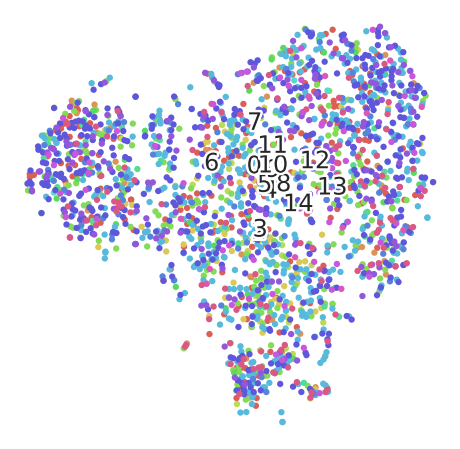

In [53]:
scatter(tsne, dim_reduction_labels);

In [55]:
label2index

{'Atelectasis': 0,
 'Cardiomegaly': 1,
 'Consolidation': 2,
 'Edema': 3,
 'Effusion': 4,
 'Emphysema': 5,
 'Fibrosis': 6,
 'Hernia': 7,
 'Infiltration': 8,
 'Mass': 9,
 'No Finding': 10,
 'Nodule': 11,
 'Pleural_Thickening': 12,
 'Pneumonia': 13,
 'Pneumothorax': 14}